In [ ]:
import os
import random
import warnings
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sys
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# mengatur parameter
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
TRAIN_PATH = '/kaggle/input/blood-testing/UNET_WBC/train'
TEST_PATH = '/kaggle/input/blood-testing/UNET_WBC/test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed(seed)
np.random.seed(seed)

# mendapatkan ID dari gambar training dan testing
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# inisiasi array dan menyimpan data
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)  # Fixed here
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

# Looping untuk mengambil gambar dan mask pada data training
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    img_path = os.path.join(path, 'images', id_ + '.png')

    # Membaca gambar
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

    # Membaca dan menggabungkan semua mask untuk setiap gambar
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_files = next(os.walk(os.path.join(path, 'masks')))[2]

    for mask_file in mask_files:
        mask_path = os.path.join(path, 'masks', mask_file)
        mask_ = imread(mask_path)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

# menyimpan dan mengubah ukuran gambar untuk data test
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Looping untuk mengambil gambar pada data test
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img_path = os.path.join(path, 'images', id_ + '.png')

    img = imread(img_path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

# Membagi data training dan testing
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('\nx_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)


Getting and resizing train images and masks ... 


100%|██████████| 670/670 [05:19<00:00,  2.10it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 27.82it/s]


Done!

x_train (536, 224, 224, 3)
x_test (134, 224, 224, 3)
y_train (536, 224, 224, 1)
y_test (134, 224, 224, 1)


In [ ]:
# Import library


# Parameter
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 50

# Fungsi IoU (Intersection over Union)
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.cast(K.flatten(y_true), 'float32')  # Konversi ke float32
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')  # Konversi ke float32
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Fungsi Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.cast(K.flatten(y_true), 'float32')  # Konversi ke float32
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')  # Konversi ke float32
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Fungsi untuk membangun U-Net dengan backbone ResNet50
def build_resnet50_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(input_shape)

    # Menggunakan ResNet50 sebagai backbone
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    # Membekukan sebagian besar layer ResNet50
    for layer in resnet50.layers[:-10]:  # Bebaskan hanya 10 layer terakhir
        layer.trainable = False

    # Encoder outputs
    c1 = resnet50.get_layer("conv1_relu").output       # 112x112
    c2 = resnet50.get_layer("conv2_block3_out").output # 56x56
    c3 = resnet50.get_layer("conv3_block4_out").output # 28x28
    c4 = resnet50.get_layer("conv4_block6_out").output # 14x14
    c5 = resnet50.get_layer("conv5_block3_out").output # 7x7

    # Decoder
    d4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
    d4 = layers.concatenate([d4, c4])
    d4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(d4)
    d4 = layers.Dropout(0.5)(d4)
    d4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(d4)

    d3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(d4)
    d3 = layers.concatenate([d3, c3])
    d3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(d3)
    d3 = layers.Dropout(0.5)(d3)
    d3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(d3)

    d2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(d3)
    d2 = layers.concatenate([d2, c2])
    d2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(d2)
    d2 = layers.Dropout(0.5)(d2)
    d2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(d2)

    d1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(d2)
    d1 = layers.concatenate([d1, c1])
    d1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(d1)
    d1 = layers.Dropout(0.5)(d1)
    d1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(d1)

    # Upsampling tambahan agar sesuai dengan ukuran ground truth (224x224)
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(d1)
    outputs = layers.UpSampling2D(size=(2, 2))(outputs)  # Upsampling ke (224, 224)

    # Model
    model = models.Model(inputs, outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy", iou_metric, dice_coefficient]
    )

    return model

In [ ]:
# Tampilkan model summary
model_resnet50_unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 84,665,861 (322.97 MB)

 Trainable params: 21,847,937 (83.34 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 43,695,876 (166.69 MB)

In [ ]:
# Bangun model
model_resnet50_unet = build_resnet50_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Callback untuk menurunkan learning rate
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
)

# Callback untuk menghentikan pelatihan lebih awal jika tidak ada perbaikan
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Latih model
history_resnet50 = model_resnet50_unet.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50


I0000 00:00:1733831437.403526      93 service.cc:145] XLA service 0x785820002ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733831437.403579      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/67 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6677 - dice_coefficient: 0.2546 - iou_metric: 0.1459 - loss: 0.6391  

I0000 00:00:1733831453.208665      93 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion', 100 bytes spill stores, 64 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 384 bytes spill stores, 384 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 356 bytes spill stores, 356 bytes spill loads

I0000 00:00:1733831453.230054      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - accuracy: 0.8192 - dice_coefficient: 0.3425 - iou_metric: 0.2236 - loss: 0.4188 - val_accuracy: 0.9426 - val_dice_coefficient: 0.7674 - val_iou_metric: 0.6238 - val_loss: 0.1348 - learning_rate: 1.0000e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9446 - dice_coefficient: 0.7670 - iou_metric: 0.6233 - loss: 0.1308 - val_accuracy: 0.9577 - val_dice_coefficient: 0.8282 - val_iou_metric: 0.7081 - val_loss: 0.1006 - learning_rate: 1.0000e-04
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9550 - dice_coefficient: 0.8147 - iou_metric: 0.6886 - loss: 0.1077 - val_accuracy: 0.9617 - val_dice_coefficient: 0.8248 - val_iou_metric: 0.7030 - val_loss: 0.0922 - learning_rate: 1.0000e-04
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9568 - dice_coefficient: 0.8267 - iou_metric: 0.7058 - loss: 0.1042 - val_accuracy: 0.9639 - val_dice_coefficient: 0.8417 - val_iou_metric: 0.7279 - val_loss: 0.0865 -

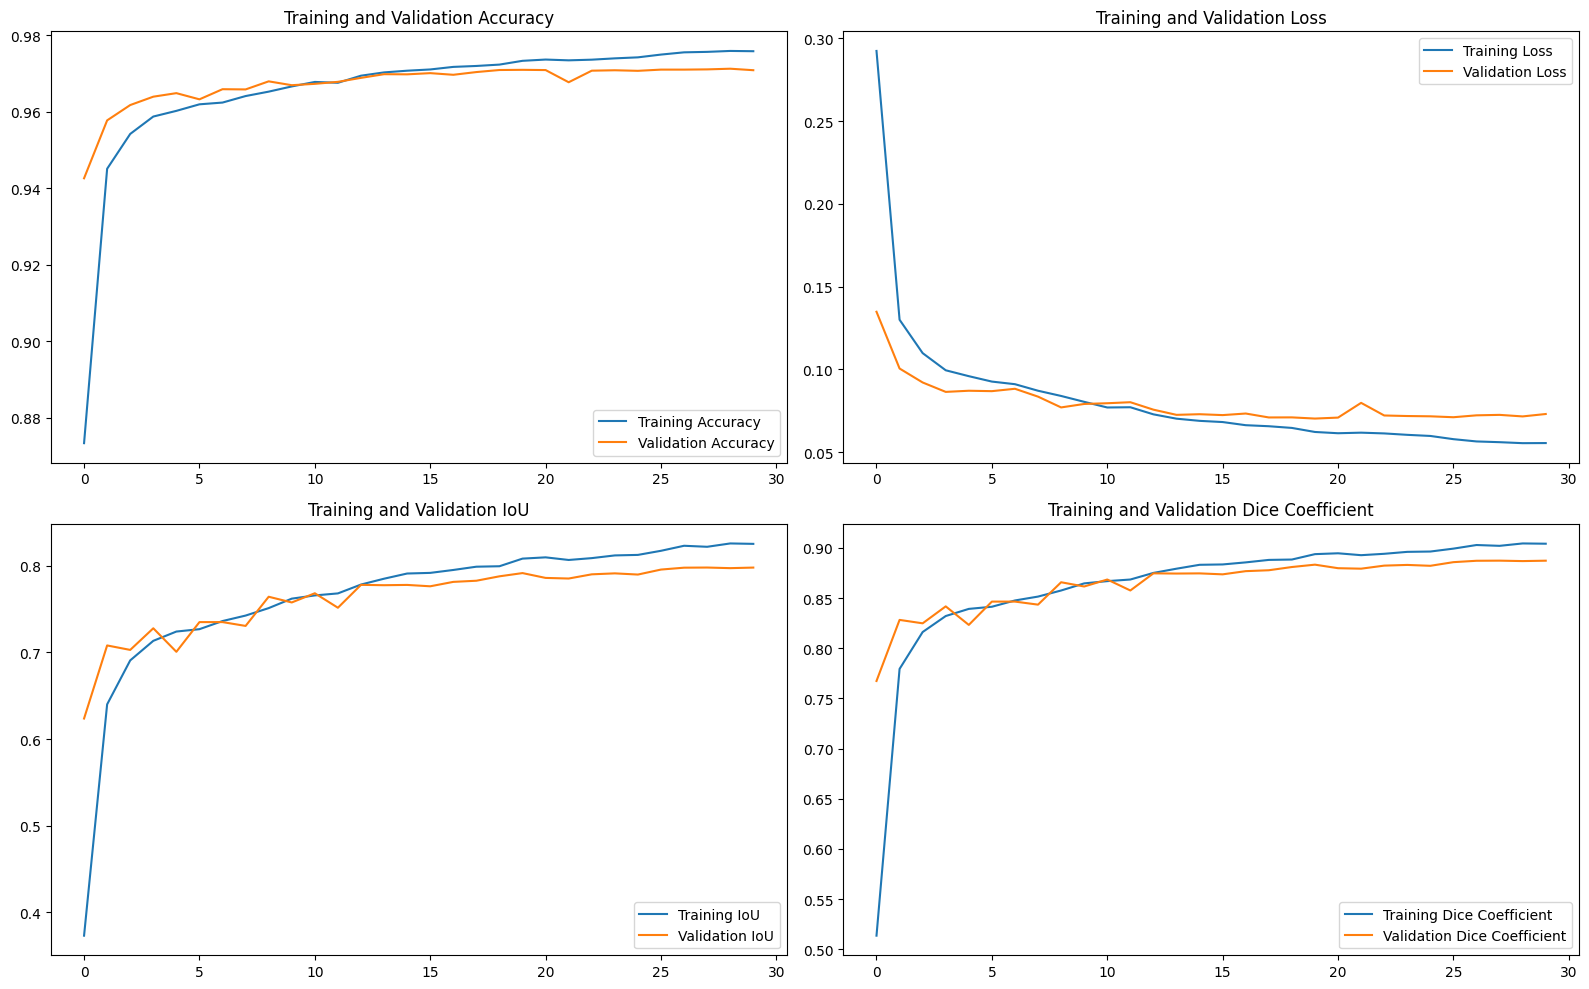

In [ ]:

# Fungsi untuk memplot hasil pelatihan
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    iou = history.history['iou_metric']
    val_iou = history.history['val_iou_metric']
    dice = history.history['dice_coefficient']
    val_dice = history.history['val_dice_coefficient']
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 10))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

    # Plot IoU
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, iou, label="Training IoU")
    plt.plot(epochs_range, val_iou, label="Validation IoU")
    plt.legend(loc="lower right")
    plt.title("Training and Validation IoU")

    # Plot Dice Coefficient
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, dice, label="Training Dice Coefficient")
    plt.plot(epochs_range, val_dice, label="Validation Dice Coefficient")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Dice Coefficient")

    plt.tight_layout()
    plt.show()

# Plot hasil pelatihan
plot_training_history(history_resnet50)

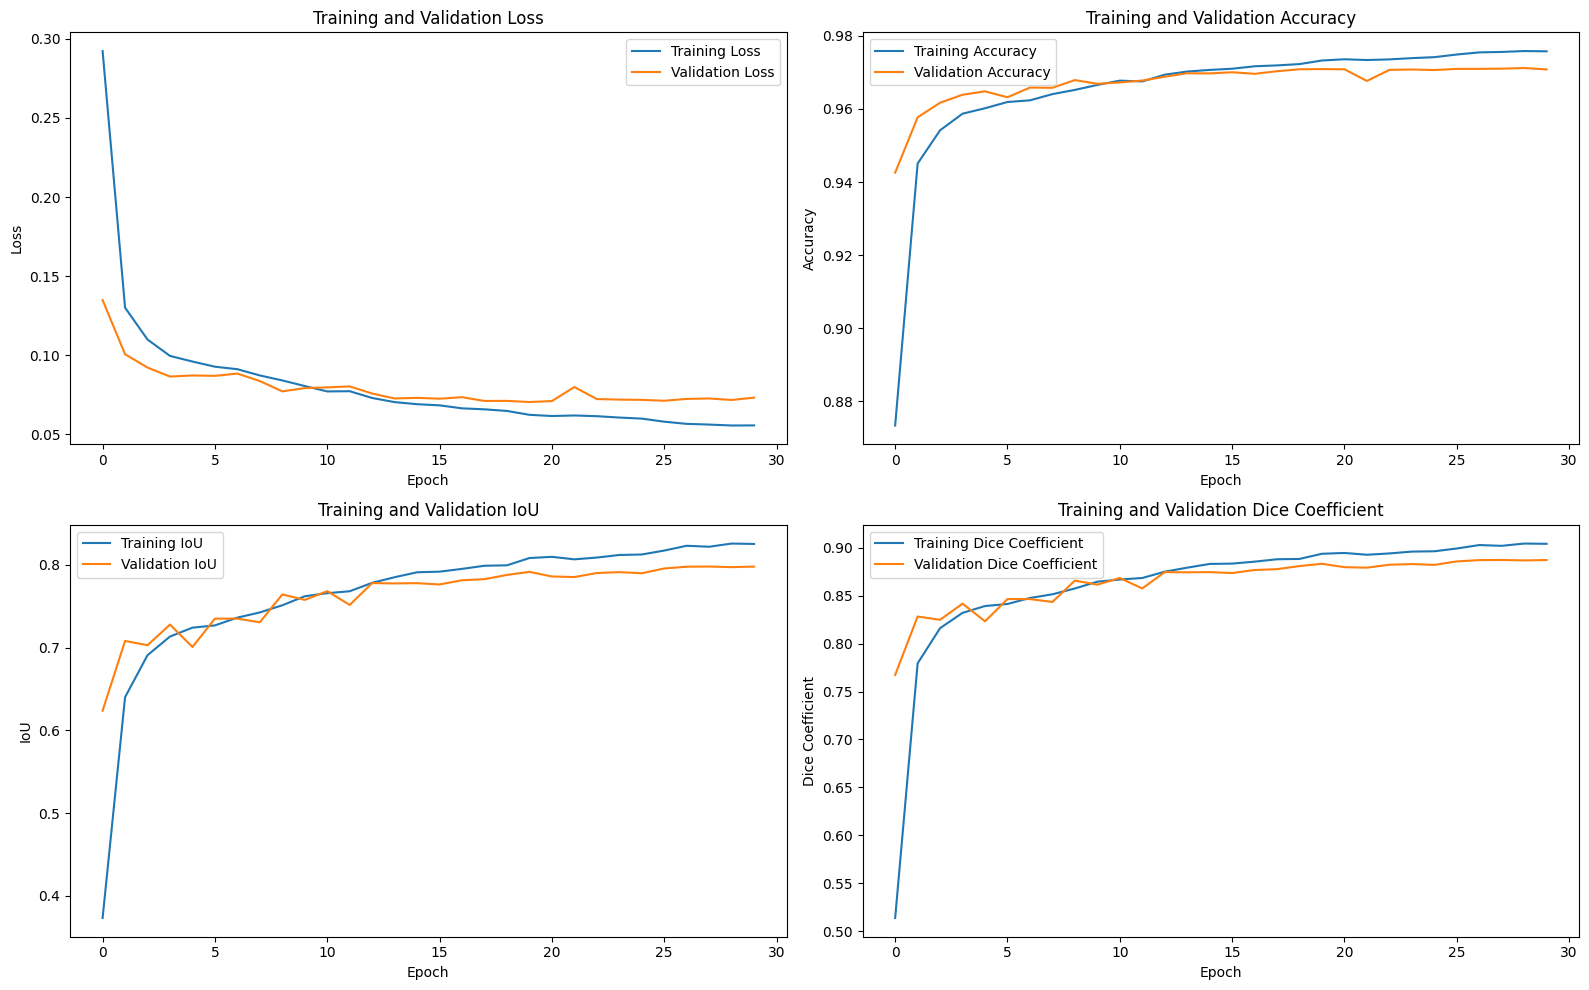

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9705 - dice_coefficient: 0.8841 - iou_metric: 0.7929 - loss: 0.0707
Test Loss: 0.0704
Test Accuracy: 0.9709
Test IoU: 0.7916
Test Dice Coefficient: 0.8832
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Accuracy: 0.9709
Precision: 0.9017
Recall: 0.9267
F1 Score: 0.9140
Confusion Matrix:
[[5489152  113244]
 [  82208 1038980]]


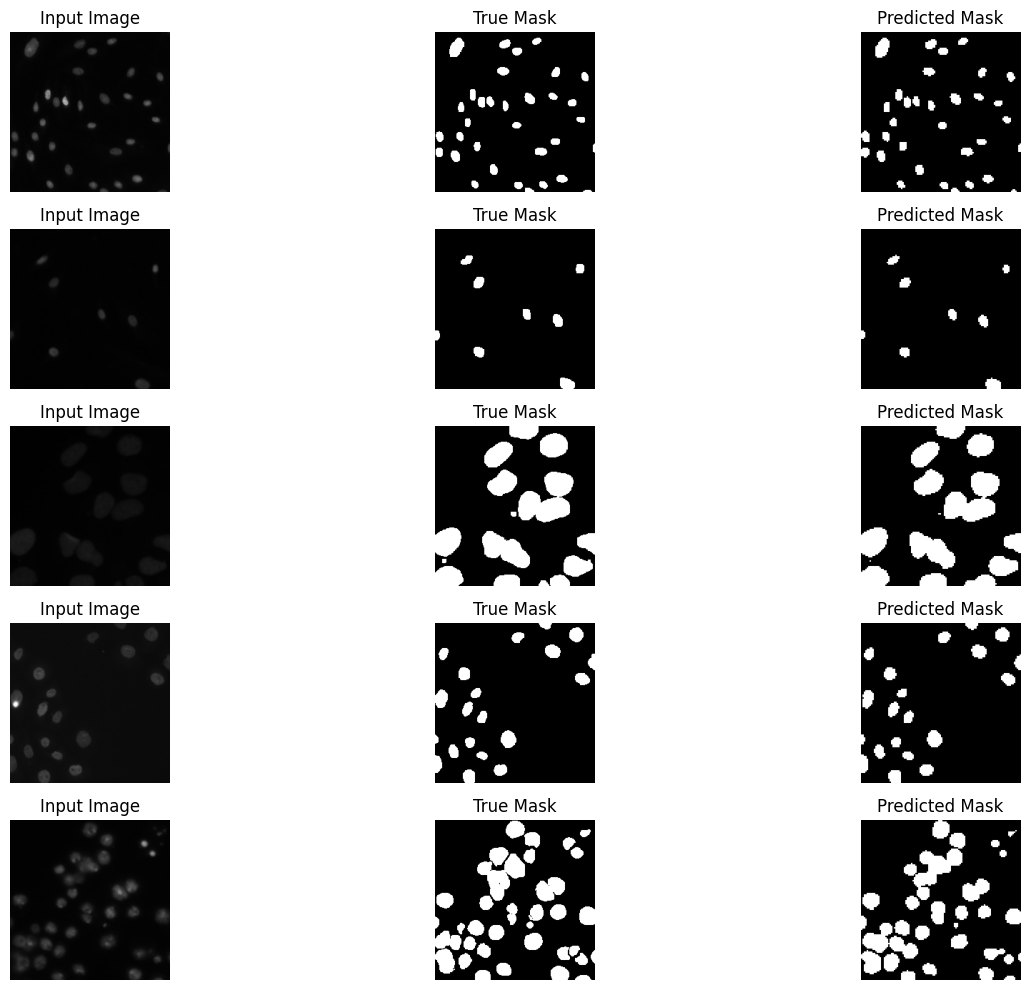

In [ ]:


# Fungsi untuk menampilkan kurva pelatihan
def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(16, 10))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot IoU
    plt.subplot(2, 2, 3)
    plt.plot(history.history['iou_metric'], label='Training IoU')
    plt.plot(history.history['val_iou_metric'], label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    # Plot Dice Coefficient
    plt.subplot(2, 2, 4)
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history
plot_training_history(history_resnet50)

# Evaluasi model di test data
test_loss, test_accuracy, test_iou, test_dice = model_resnet50_unet.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test IoU: {test_iou:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")

# Prediksi pada test data
y_pred = model_resnet50_unet.predict(x_test, batch_size=BATCH_SIZE, verbose=1)
y_pred = (y_pred > 0.5).astype(np.uint8)  # Binarize output dengan threshold 0.5

# Hitung metrik evaluasi
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
print("Confusion Matrix:")
print(cm)

# Visualisasi sampel prediksi
def visualize_predictions(x, y_true, y_pred, n_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        idx = np.random.randint(0, len(x))  # Pilih indeks acak
        plt.subplot(n_samples, 3, i * 3 + 1)
        plt.imshow(x[idx])
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(n_samples, 3, i * 3 + 2)
        plt.imshow(y_true[idx].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(n_samples, 3, i * 3 + 3)
        plt.imshow(y_pred[idx].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualisasi prediksi pada data uji
visualize_predictions(x_test, y_test, y_pred)
